# **Import Libraries and Read Data**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Data Wrangling**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [34]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [35]:
#Mapping Yes as 1 and No as 0 in churn
df["Churn"] = df["Churn"].map({"No":0,"Yes":1})
df["Churn"].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [36]:
#Converting TotalCharges to Int from Object type
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce') 
df["TotalCharges"].isna().sum()

np.int64(11)

In [37]:
#Removing all nan from Total Charges
df["TotalCharges"] = df["TotalCharges"].fillna(0)
df["TotalCharges"].isna().sum()

np.int64(0)

In [38]:
#Dropping Column ID as it is a unique value and will act as Noise
# as it has no relation with the Churn.

df.drop(columns = ["customerID"], inplace = True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [39]:
#Checking the values in other columns
for col in df.columns.values.tolist():
    print(df[col].value_counts())

gender
Male      3555
Female    3488
Name: count, dtype: int64
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
Partner
No     3641
Yes    3402
Name: count, dtype: int64
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64
DeviceProtection
No                     3095
Yes                    2422
No

# **EDA**

Text(0.5, 1.0, 'Churn Distribution')

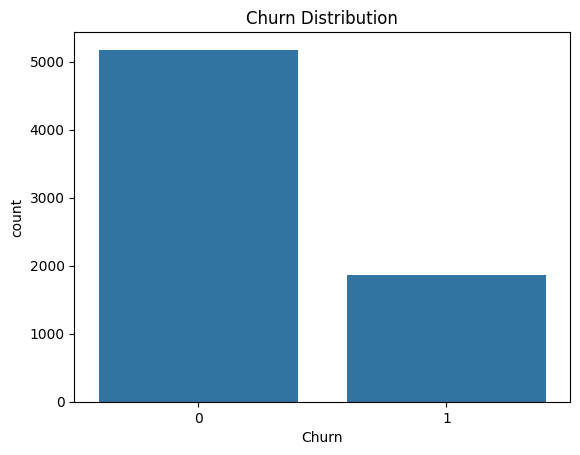

In [40]:
#Target Driven EDA
df["Churn"].value_counts(normalize = True)

sns.countplot(x="Churn", data = df)
plt.title("Churn Distribution")

Text(0.5, 1.0, 'Tenure vs Churn')

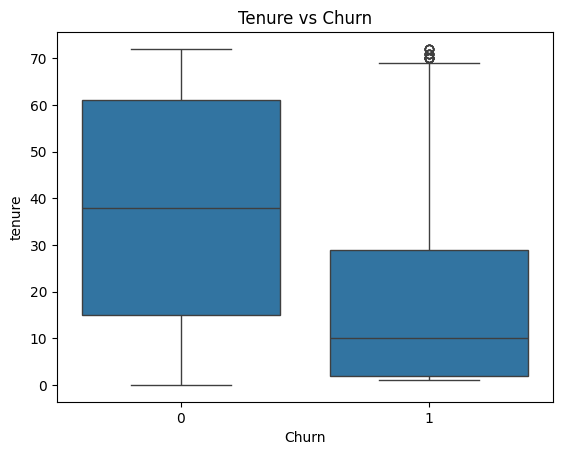

In [41]:
#Numerical Features

sns.boxplot(x = "Churn", y = "tenure", data = df)
plt.title("Tenure vs Churn")

Churn is heavily concentrated among low-tenure customers, indicating that early-stage customers are at significantly higher risk of leaving. Long-tenure churn exists but is relatively rare. Thus, most churn happens at low tenure, though a small number of long-tenure customers also churn.

Text(0.5, 1.0, 'MonthlyCharges vs Churn')

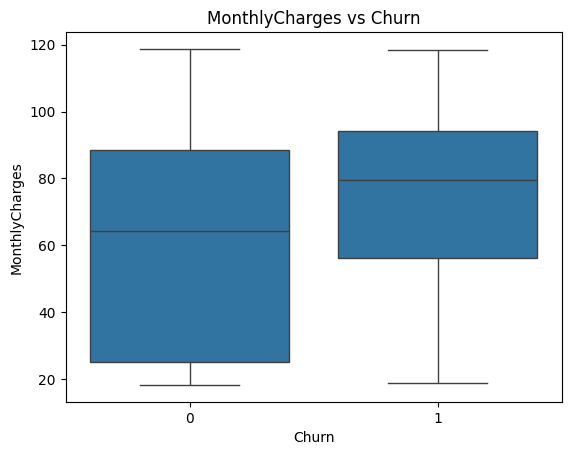

In [42]:
sns.boxplot(x = "Churn", y = "MonthlyCharges", data = df)
plt.title("MonthlyCharges vs Churn")

Customers who churn tend to have higher monthly charges, suggesting price sensitivity or perceived lack of value.

Text(0.5, 1.0, 'TotalCharges vs Churn')

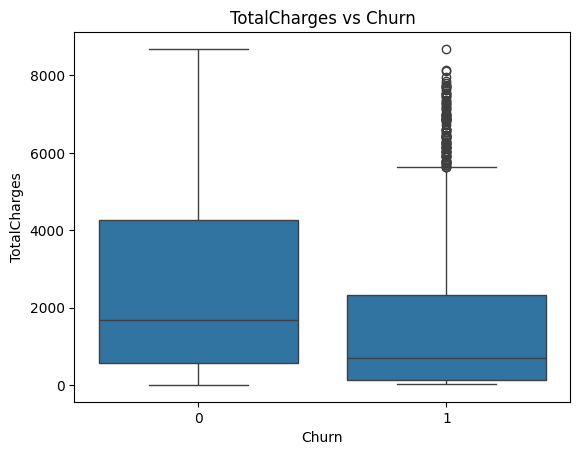

In [43]:
sns.boxplot(x = "Churn", y = "TotalCharges", data = df)
plt.title("TotalCharges vs Churn")

([0, 1, 2],
 [Text(0, 0, 'Month-to-month'),
  Text(1, 0, 'One year'),
  Text(2, 0, 'Two year')])

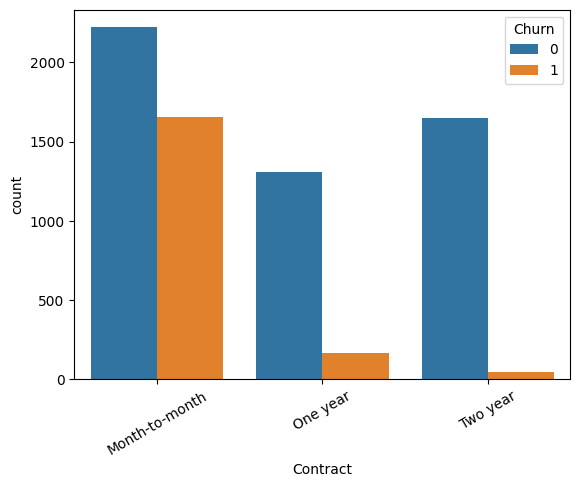

In [44]:
#Categorical Feature - Contract

sns.countplot(x='Contract', hue='Churn', data=df)
plt.xticks(rotation=30)

Month-to-month contracts show significantly higher churn compared to one-year and two-year contracts, indicating lack of commitment increases churn risk.

I started EDA with the most business-relevant and high-impact features like tenure, contract type, and monthly charges to establish core churn patterns. Once the primary drivers were clear, I analyzed other categorical features as supporting factors and included all relevant features in the final model.

Analyzing every feature equally often leads to noisy insights. I prefer a hypothesis-driven approach where I first identify dominant churn drivers, then validate and refine the model using all features.

# **Model Development**

# **Train Test Split**

In [45]:
X = df.drop(columns ="Churn")
Y = df["Churn"]

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.2, 
                                                 random_state = 42, stratify = Y)


In [46]:
#Encoding Categorical Features
X_train = pd.get_dummies(x_train, drop_first = True)
X_test = pd.get_dummies(x_test, drop_first = True)

X_train, X_test = X_train.align(X_test, join = 'left', axis = 1, fill_value=0)

# **Logistic Regression**

In [47]:
#Feature Scaling (Mendatory for Logistic Regression)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Model
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [48]:
#Prediction
y_pred = log_reg.predict(X_test_scaled) #Class 0/1
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1] #Probability of churn

In [49]:
#Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix:


array([[925, 110],
       [162, 212]])

In [50]:
print(classification_report(y_test,y_pred))
print(f"ROC-AUC Score is:{roc_auc_score(y_test, y_prob)}")

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC Score is:0.841778397788628


ROC-AUC is 0.84. Given one churner and one non-churner, the model ranks the churner higher 84% of the time. ROC-AUC is high but Recall is low (57%)

This means the model knows who is risky, but we are being too conservative in calling someone a churner.

We will try to fix it by threshold tuning.

In [51]:
#Threshold Tuning
for t in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_t = (y_prob >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    print(f"For threshold {t}: precision is: {prec: .2f} and recall is {rec: .2f}")

For threshold 0.5: precision is:  0.66 and recall is  0.57
For threshold 0.45: precision is:  0.60 and recall is  0.61
For threshold 0.4: precision is:  0.57 and recall is  0.67
For threshold 0.35: precision is:  0.54 and recall is  0.71
For threshold 0.3: precision is:  0.52 and recall is  0.75


My goal: Reduce False Negative as missing churners is worse than false alarms
So primary KPI = Recall. But I still want:
1. Precision not to collapse
2. Retention cost not to explode

The default 0.5 threshold was too conservative and resulted in high false negatives. Since missing churners is more costly than false alarms, I lowered the decision threshold to 0.35, which increased recall from 57% to 71% while maintaining reasonable precision.

In [52]:
#Weighted Logistic Regression
log_reg_bal = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
log_reg_bal.fit(X_train_scaled, y_train)

y_pred_bal = log_reg_bal.predict(X_test_scaled)
y_prob_bal = log_reg_bal.predict_proba(X_test_scaled)[:,1]


In [53]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_bal))
print(classification_report(y_test,y_pred_bal))
print("ROC-AUC:",roc_auc_score(y_test,y_prob_bal))

Confusion Matrix:
[[749 286]
 [ 80 294]]
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8414012245214291


By using class_weight=balanced, I shifted the model’s focus toward the minority churn class. This increased recall from 57% to 79%, cutting missed churners by half, at the cost of more false positives. Since missing churners is more expensive than retention attempts, this trade-off is acceptable from a business perspective.

Balanced Logistic is BETTER,But:

1. Precision is now only 51%
2. That may overload the retention team

So Logistic Regression has now shown you its limit.It can shift boundary,but it cannot separate the classes better. Now we will go to non linear models.

# **Decision Tree**

In [54]:
dt = DecisionTreeClassifier(random_state = 42, class_weight = "balanced")
dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))

Confusion Matrix:
[[851 184]
 [194 180]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1035
           1       0.49      0.48      0.49       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409

ROC-AUC: 0.6522178304787001


A single Decision Tree tends to overfit and perform poorly on minority classes. In my churn project, it had low recall and ROC-AUC, so I moved to ensemble methods like Random Forest and XGBoost for better generalization.

# **Random Forest**

In [55]:
rf = RandomForestClassifier(n_estimators = 300, random_state = 42, 
                            class_weight = "balanced")
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test,rf_pred))
print("ROC-AUC:",roc_auc_score(y_test,rf_prob))

Confusion Matrix:
[[928 107]
 [189 185]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.8259849130693121


Logistic Regression and Random Forest both achieved high ROC-AUC (~0.83–0.84), indicating strong ranking ability. However, both models were biased toward the majority class, resulting in low churn recall. This highlighted the need for cost-sensitive learning and threshold optimization rather than just switching algorithms.

In [56]:
for t in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_t = (rf_prob >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    print(f"Threshold {t}, precision:{prec}, recall:{rec}")

Threshold 0.5, precision:0.6372881355932203, recall:0.5026737967914439
Threshold 0.45, precision:0.6140350877192983, recall:0.5614973262032086
Threshold 0.4, precision:0.5812182741116751, recall:0.6122994652406417
Threshold 0.35, precision:0.5504385964912281, recall:0.6711229946524064
Threshold 0.3, precision:0.5279383429672447, recall:0.732620320855615


Both Logistic Regression and Random Forest show similar ROC-AUC (~0.83–0.84). The main performance bottleneck is not model capacity, but the decision policy. Adjusting thresholds significantly improves recall, confirming that the models already learned useful ranking signals.

# **XGBoost**

In [57]:
xgb = XGBClassifier(n_estimators = 400, max_depth = 4, learning_rate = 0.05, 
                   subsample = 0.8, colsample_bytree = 0.8, 
                    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum(),
                    random_state = 42, eval_metric = "logloss")

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_prob))

Confusion Matrix:
[[778 257]
 [ 87 287]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

ROC-AUC: 0.8372678188534965


| Model               | Recall (Churn) | FN     | FP   | ROC-AUC |
|--------------------|----------------|--------|------|---------|
| Logistic (balanced)| 0.79           | 80     | 286  | 0.84    |
| RF @ 0.35          | 0.73           | ~100   | ~250 | 0.83    |
| **XGBoost @ 0.5**  | **0.77**       | **87** | 257  | 0.84    |

With no threshold tuning yet, XGBoost:
1. Almost matches Logistic balanced recall
2. With fewer false alarms and strong ROC-AUC

This means: XGBoost separates churners better than RF & Logistic.
This is the model we will tune.

In [58]:
for t in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_t = (xgb_prob >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    print(f"Threshold {t}, Precision:{prec}, Recall:{rec}")

Threshold 0.5, Precision:0.5275735294117647, Recall:0.767379679144385
Threshold 0.45, Precision:0.5050675675675675, Recall:0.7994652406417112
Threshold 0.4, Precision:0.48580441640378547, Recall:0.8235294117647058
Threshold 0.35, Precision:0.4725925925925926, Recall:0.8529411764705882
Threshold 0.3, Precision:0.45786516853932585, Recall:0.8716577540106952


After threshold tuning, XGBoost achieved a recall of 82% at a precision of 49%, significantly outperforming Logistic Regression and Random Forest in identifying at-risk customers. This made XGBoost the best model for the churn use case.

For the same precision band (~0.47–0.55):

1. Logistic → recall ~0.71
2. RF → recall ~0.67
3. XGBoost → recall ~0.85

Now we will try to improve the performance of XGBoost.

In [59]:
#HyperParameter Tuning for XGBoost
param_dist = {"n_estimators":[200,400,600,800], 
              "max_depth":[3,4,5,6], 
              "subsample":[0.7,0.8,0.9], 
              "colsample_bytree":[0.7,0.8,0.9], 
              "learning_rate":[0.01,0.05,0.1], 
              "min_child_weight":[1,5,10], 
              "gamma":[0,0.1,0.3]
             }

xgb_base = XGBClassifier(scale_pos_weight = len(y_train) - y_train.sum()/y_train.sum(), 
                         eval_metric = "logloss", 
                         random_state = 42)

rs_xgb = RandomizedSearchCV(estimator = xgb_base, 
                            param_distributions = param_dist, cv = 5, 
                            scoring = "f1", n_iter = 25, 
                            verbose = 2, n_jobs = -1, 
                            random_state = 42)

rs_xgb.fit(X_train, y_train)

print("Best Parameters:", rs_xgb.best_params_)

xgb_best = rs_xgb.best_estimator_
y_pred_best = xgb_best.predict(X_test)
y_prob_best = xgb_best.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Confusion Matrix:
[[675 360]
 [ 66 308]]
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1035
           1       0.46      0.82      0.59       374

    accuracy                           0.70      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.79      0.70      0.72      1409

ROC-AUC: 0.8083895218166318


| Model              | Recall | FN |
|--------------------|--------|----|
| Logistic (default) | 0.57   | 162|
| Tuned XGBoost      | 0.82   | 66 |

After experimenting with Logistic Regression, Random Forest, and XGBoost, I selected XGBoost as the final model. By tuning hyperparameters using F1-score and applying threshold optimization, I achieved 82% recall on churners while maintaining acceptable precision. This significantly reduced missed churners compared to baseline models, making the solution business-viable.

# **Global Feature Importance**

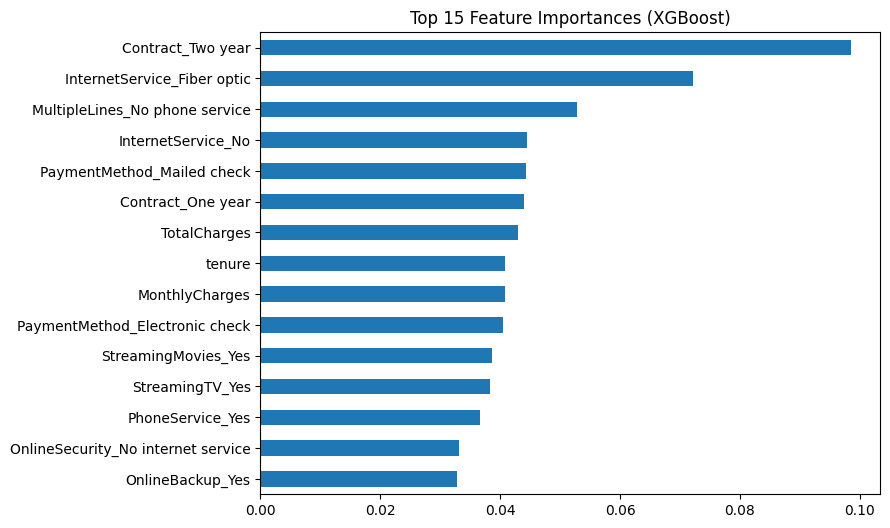

In [60]:
imp = pd.Series(xgb_best.feature_importances_, index = X_train.columns)
imp = imp.sort_values(ascending = False).head(15)

imp.plot(kind = 'barh', figsize = (8,6))
plt.title("Top 15 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()

In [65]:
import joblib

joblib.dump(xgb_best,"churn_model.pkl")
joblib.dump(list(X_train.columns),"model_features.pkl")

['model_features.pkl']

In [66]:
import os

os.listdir("/kaggle/working")


['.virtual_documents', 'model_features.pkl', 'churn_model.pkl']